In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

from scipy import stats
import math as m
import numpy as np
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('TTF_2.xlsx', skiprows=lambda x: x in [0, 2], usecols='C:D', names=('Date', 'Spot'))
df.head()

,Date,Spot
0,2016-01-01,165.568
1,2016-01-04,162.760
2,2016-01-05,161.200
3,2016-01-06,162.240
4,2016-01-07,162.552


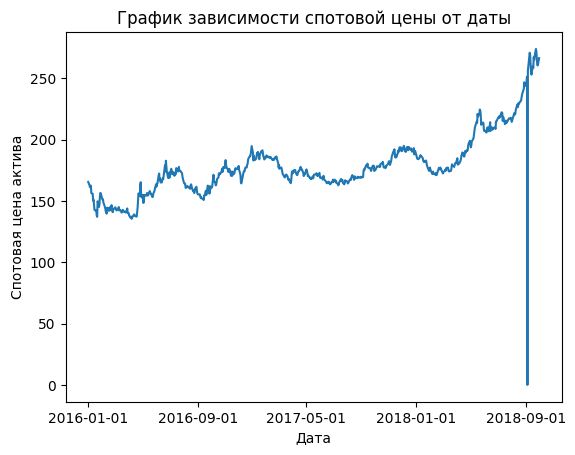

In [3]:
plt.plot(df['Date'], df['Spot'])
plt.xlabel('Дата')
plt.ylabel('Спотовая цена актива')
plt.title('График зависимости спотовой цены от даты')
plt.xticks(plt.xticks()[0][0::2])
plt.show()

In [4]:
df[df['Spot'] == df['Spot'].min()]

,Date,Spot
695,2018-09-05,0.0


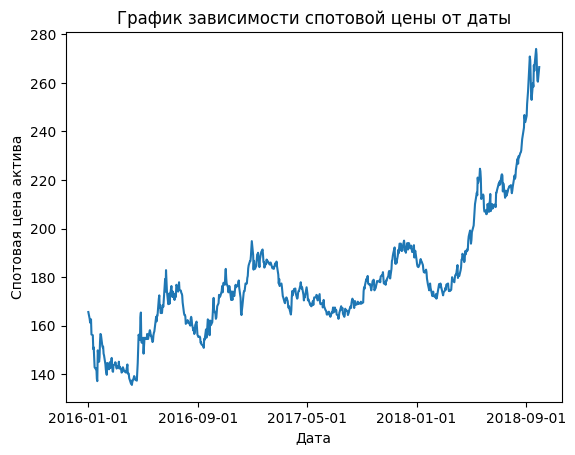

In [5]:
df.iloc[df['Spot'].argmin(), 1] = (df.iloc[df['Spot'].argmin() - 1 , 1] + df.iloc[df['Spot'].argmin() + 1 , 1]) / 2

plt.plot(df['Date'], df['Spot'])
plt.xlabel('Дата')
plt.ylabel('Спотовая цена актива')
plt.title('График зависимости спотовой цены от даты')
plt.xticks(plt.xticks()[0][0::2])
plt.show()

In [6]:
df

,Date,Spot
0,2016-01-01,165.568
1,2016-01-04,162.760
2,2016-01-05,161.200
3,2016-01-06,162.240
4,2016-01-07,162.552
...,...,...
709,2018-09-25,271.752
710,2018-09-26,265.200
711,2018-09-27,261.040
712,2018-09-28,260.520


### Расчет цены покупки и продажи актива

In [7]:
base_price = df[df['Date'] == '2018-10-01']['Spot'].values[0]
buy_price = min(df[df['Date'] == '2018-10-01']['Spot'].values[0] + 2, 260)
sell_price = df[df['Date'] == '2018-10-01']['Spot'].values[0]

print(f'Базовая цена актива на день начала контракта: {base_price}')
print(f'Цена покупки актива на день начала контракта: {buy_price}')
print(f'Цена продажи актива на день начала контракта: {sell_price}')

Базовая цена актива на день начала контракта: 266.552
Цена покупки актива на день начала контракта: 260
Цена продажи актива на день начала контракта: 266.552


### Волатильность

In [8]:
def volatility(x):
    q1 = sum(x) / len(x)
    q2 = (x - q1) ** 2
    q3 = sum(q2)
    q4 = q3 / (len(x) - 1)
    q5 = q4 ** (1/2)
    return q5 

In [9]:
sigma = volatility(df[df['Date'] >= '2018-04-01']['Spot'])
sigma

23.485310957860488

### Создание контрольного датасета

In [10]:
start_date = dt.datetime(2018, 10, 1)
end_date = dt.datetime(2019, 3, 31)
df2 = pd.DataFrame(data=pd.date_range(start_date, end_date), columns=['Date'])
df2['days_left'] = df2['Date'].apply(lambda x: end_date - x).dt.days
df2

,Date,days_left
0,2018-10-01,181
1,2018-10-02,180
2,2018-10-03,179
3,2018-10-04,178
4,2018-10-05,177
...,...,...
177,2019-03-27,4
178,2019-03-28,3
179,2019-03-29,2
180,2019-03-30,1


### Стоимость опциона по формуле Блэка-Шоулза

In [11]:
# Приведение к нормальному распределению
def N_cdf(x):
    return stats.norm.cdf(x, 0.0, 1.0)
    
# Расчет коэффициента d1
def bsm_d1(S, K, T, r, sigma):
    S = float(S)
    return (m.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

# Расчет коэффициента d2
def bsm_d2(S, K, T, r, sigma):
    S = float(S)
    return (m.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

# Расчет стоимости опциона на покупку
def bsm_call_pv(S, K, T, r, sigma):
    d1 = bsm_d1(S, K, T, r, sigma)
    d2 = bsm_d2(S, K, T, r, sigma)
    return S * N_cdf(d1) - K * m.exp(-r * T) * N_cdf(d2)

# Расчет стоимости опциона на продажу
def bsm_put_pv(S, K, T, r, sigma):
    d1 = bsm_d1(S, K, T, r, sigma)
    d2 = bsm_d2(S, K, T, r, sigma)
    return  - S * N_cdf(-d1) + K * m.exp(-r * T) * N_cdf(-d2)

In [12]:
for i in range(len(df2)):
    df2.loc[i, 'bs_option_call'] = bsm_call_pv(base_price, buy_price, df2.loc[i, 'days_left'] / 365, 0.05, sigma) * 1000
    
    df2.loc[i, 'bs_option_put'] = bsm_put_pv(base_price, sell_price, df2.loc[i, 'days_left'] / 365, 0.05, sigma) * 1000

df2.iloc[-1, -1] = 0
df2

,Date,days_left,bs_option_call,bs_option_put
0,2018-10-01,181,266552.000000,260024.231819
1,2018-10-02,180,266552.000000,260059.854016
2,2018-10-03,179,266552.000000,260095.481094
3,2018-10-04,178,266552.000000,260131.113052
4,2018-10-05,177,266552.000000,260166.749892
...,...,...,...,...
177,2019-03-27,4,208925.107648,208055.659655
178,2019-03-28,3,190999.336695,189940.831060
179,2019-03-29,2,165290.961052,163944.838280
180,2019-03-30,1,124732.377294,122908.876368


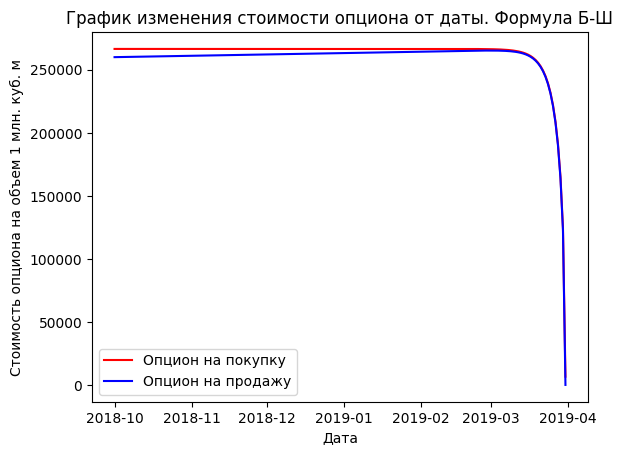

In [68]:
plt.plot(df2['Date'], df2['bs_option_call'], c='red', label='Опцион на покупку')
plt.plot(df2['Date'], df2['bs_option_put'], c='blue', label='Опцион на продажу')
plt.xlabel('Дата')
plt.ylabel('Стоимость опциона на объем 1 млн. куб. м')
plt.title('График изменения стоимости опциона от даты. Формула Б-Ш')
plt.legend()
plt.show()

### Стоимость опциона по биномиальной модели

In [22]:
def gen_lattice(S0, u, d, N):
    #Создаем биномиальное дерево
    S = [float(S0)]
    for i in range(1, N+1):
        for j in range(0, i+1):
            S.append(round(S0 * d**j * u**(i-j), 2))
    return S

S0 = 260
N = 5
u = 1.1
d = 1/1.1
S = gen_lattice(S0 = S0, N=N, u = u, d = d)

L = N + 1
print(f'Число уровней: {L}, длина массива: {len(S)}, номер первого узла в последнем уровне: {len(S)-L}')
print('-------')
print('Значения на последнем уровне:')
for i in range(len(S)-L, len(S)):
    print(S[i])
print('----\n\n')

k = len(S)-L-1
for i in reversed(range(1, L)):
    for j in range(0, i):
        print(f'{S[k]} соединен с {S[k+i]} и с {S[k+i+1]}')
        k = k - 1
    print('-----')

Число уровней: 6, длина массива: 21, номер первого узла в последнем уровне: 15
-------
Значения на последнем уровне:
418.73
346.06
286.0
236.36
195.34
161.44
----


177.58 соединен с 195.34 и с 161.44
214.88 соединен с 236.36 и с 195.34
260.0 соединен с 286.0 и с 236.36
314.6 соединен с 346.06 и с 286.0
380.67 соединен с 418.73 и с 346.06
-----
195.34 соединен с 214.88 и с 177.58
236.36 соединен с 260.0 и с 214.88
286.0 соединен с 314.6 и с 260.0
346.06 соединен с 380.67 и с 314.6
-----
214.88 соединен с 236.36 и с 195.34
260.0 соединен с 286.0 и с 236.36
314.6 соединен с 346.06 и с 286.0
-----
236.36 соединен с 260.0 и с 214.88
286.0 соединен с 314.6 и с 260.0
-----
260.0 соединен с 286.0 и с 236.36
-----


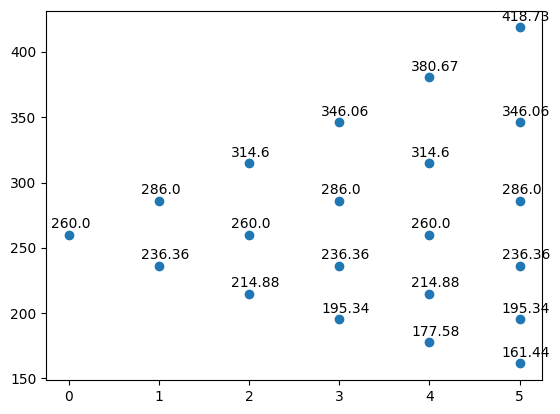

In [28]:
l = []
for i in range(0, 7):
    for j in range(1, i+1):
        l.append(i-1)
plt.scatter(l, S)
for i in range(len(S)): 
    plt.annotate(S[i], (l[i] - 0.2, S[i] + 5))

In [64]:
def pv_crr(type, S0, K, T, r, sigma, N):
    dt = T / N
    #Зададим параметры дерева
    u = m.exp(sigma * m.sqrt(dt))
    d = 1 / u
    p = (m.exp(r * dt) - d) / (u - d)
    q = 1 - p
    #Генерируем само дерево
    S = gen_lattice(S0=S0, N=N, u=u, d=d)
    Price = gen_lattice(S0=S0, N=N, u=u, d=d)
    L = N + 1
    
    payoff = lambda x: max(0, x - K) if type == 'call' else max(0, K - x)
    #Просчитываем последний слой биномиального дерева с помощью payoff
    for i in range(len(S)-L, len(S)):
        Price[i] = payoff(S[i])
    k = len(S) - L - 1
    for i in reversed(range(1, L)):
        for j in range(0, i):
            fu = Price[k+i]
            fd = Price[k+i+1]
            price = m.exp(-r*dt)*(p*fu + q*fd)
            Price[k] = price
            k = k-1
    return Price

In [86]:
for i in range(len(df2)):
    df2.loc[i, 'binom_option_call'] = pv_crr(type = 'call', S0=base_price, K=buy_price, T=df2.loc[i, 'days_left'] / 365, r=0.05,
                                            sigma=sigma, N=df2.loc[i, 'days_left'])[0] * 1000
    
    df2.loc[i, 'binom_option_put'] = pv_crr(type = 'put', S0=base_price, K=sell_price, T=df2.loc[i, 'days_left'] / 365, r=0.05,
                                            sigma=sigma, N=df2.loc[i, 'days_left'])[0] * 1000

df2

,Date,days_left,bs_option_call,bs_option_put,binom_option_call,binom_option_put
0,2018-10-01,181,266552.000000,260024.231819,266552.000000,260024.231819
1,2018-10-02,180,266552.000000,260059.854016,266552.000000,260059.854016
2,2018-10-03,179,266552.000000,260095.481094,266552.000000,260095.481094
3,2018-10-04,178,266552.000000,260131.113052,266552.000000,260131.113052
4,2018-10-05,177,266552.000000,260166.749892,266552.000000,260166.749892
...,...,...,...,...,...,...
177,2019-03-27,4,208925.107648,208055.659655,198476.164711,196872.675285
178,2019-03-28,3,190999.336695,189940.831060,197870.034288,196904.706912
179,2019-03-29,2,165290.961052,163944.838280,148551.608165,145848.029105
180,2019-03-30,1,124732.377294,122908.876368,147398.175448,145876.149698


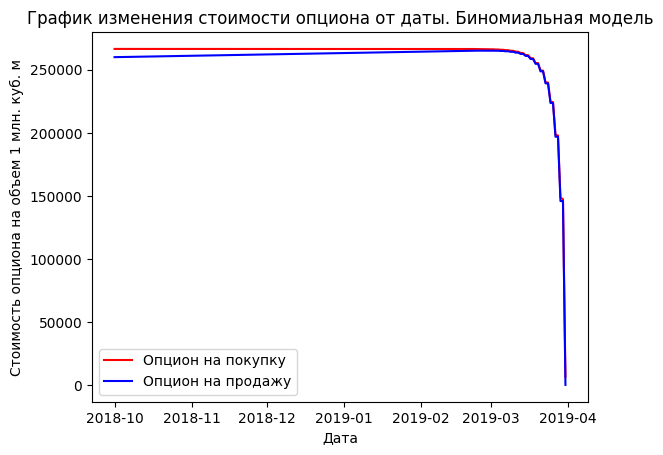

In [87]:
plt.plot(df2['Date'], df2['binom_option_call'], c='red', label='Опцион на покупку')
plt.plot(df2['Date'], df2['binom_option_put'], c='blue', label='Опцион на продажу')
plt.xlabel('Дата')
plt.ylabel('Стоимость опциона на объем 1 млн. куб. м')
plt.title('График изменения стоимости опциона от даты. Биномиальная модель')
plt.legend()
plt.show()

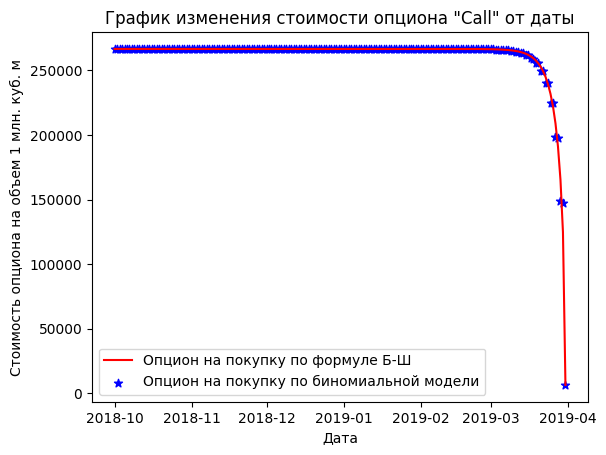

In [88]:
plt.plot(df2['Date'], df2['bs_option_call'], c='red', label='Опцион на покупку по формуле Б-Ш')
plt.scatter(df2['Date'], df2['binom_option_call'], c='blue', label='Опцион на покупку по биномиальной модели', marker='*')
plt.xlabel('Дата')
plt.ylabel('Стоимость опциона на объем 1 млн. куб. м')
plt.title('График изменения стоимости опциона "Call" от даты')
plt.legend()
plt.show()

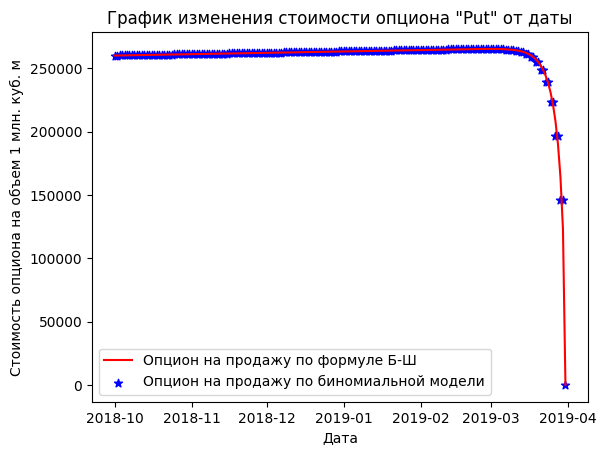

In [81]:
plt.plot(df2['Date'], df2['bs_option_put'], c='red', label='Опцион на продажу по формуле Б-Ш')
plt.scatter(df2['Date'], df2['binom_option_put'], c='blue', label='Опцион на продажу по биномиальной модели', marker='*')
plt.xlabel('Дата')
plt.ylabel('Стоимость опциона на объем 1 млн. куб. м')
plt.title('График изменения стоимости опциона "Put" от даты')
plt.legend()
plt.show()

In [94]:
round(sum(df2['binom_option_call'])  - sum(df2['binom_option_put']), 2) 

613377.72